In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Download Gold Price Data

This dataset contains chronological data with regards to the price of gold. We will download and load it in a pandas data frame called `df`.

In [495]:
df = pd.read_csv("https://raw.githubusercontent.com/ralampay/pattern-recognition-course/master/notebooks/FINAL_USO.csv")

# This examines the first 10 rows of the data frame
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000
5,2011-12-22,156.350006,156.800003,155.330002,156.039993,156.039993,9888400,124.629997,125.400002,124.230003,...,51.770000,52.400002,49.656178,13179600,38.270000,38.549999,38.209999,38.279999,38.279999,5376800
6,2011-12-23,156.350006,156.490005,155.820007,156.309998,156.309998,3565100,125.669998,126.430000,125.410004,...,52.349998,52.790001,50.169365,4729000,38.470001,38.610001,38.369999,38.490002,38.490002,2162200
7,2011-12-27,155.080002,155.550003,154.539993,154.910004,154.910004,4918600,126.169998,126.820000,126.059998,...,51.680000,51.869999,49.295036,4786400,38.490002,39.209999,38.459999,39.060001,39.060001,7834100
8,2011-12-28,154.050003,154.259995,150.660004,151.029999,151.029999,16436100,126.510002,126.529999,124.730003,...,50.009998,50.060001,47.574883,14170400,38.880001,38.889999,38.189999,38.340000,38.340000,5654300
9,2011-12-29,149.089996,150.720001,148.270004,150.339996,150.339996,19812200,125.239998,126.250000,124.860001,...,49.220001,51.200001,48.658298,12196600,38.389999,38.459999,37.869999,38.410000,38.410000,8924300


# Observing Time Series Data

Since all the columns in the dataset relate to the price of gold, let's have a variable `attribute` to represent the column we want to examine. Change the value to the name of the column in the dataset and observe the resulting plot.**bold text**

In [496]:
attribute = 'Low'

## Plot Time Series

We then use the `attribute` variable as filter to data frame `df` and plot the graph using `.plot()`.

<Axes: >

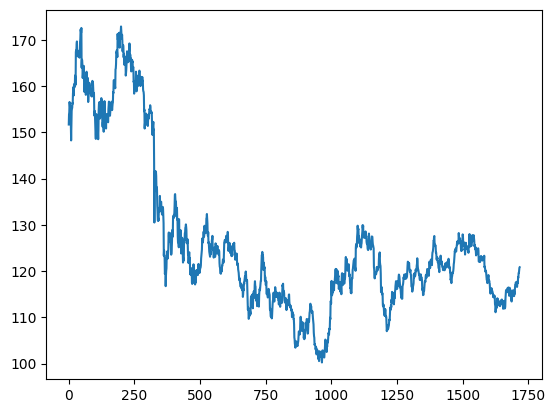

In [497]:
df[attribute].plot()

# Extracting `X` and `Y`

To define our `X` dataset and labels `Y`, we first need to define a sequence length (given by variable `sequence_length`) to define the length of a single observation / pattern. For example, if `sequence_length = 5` then a single `x` observation is `5` consecutive measurements. We also define a function `sliding_window()` which accepts the entire chronological data as an array and the `sequence_length` to return two values: An array of `x` observations with length `sequence_length` and an array of `y` corresponding to the next values of each `x` observation. We would also maintain a ratio to represent how much of the `x` observations and `y` labels will belong to the training set and which ones will belong to the test set.

In [498]:
def sliding_window(data, seq_length, pred_length):
    x = []
    y = []

    for i in range(len(data) - ((seq_length + pred_length)-1)):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:(i+seq_length)+pred_length]

        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)
   

In [499]:
# Change this value to change the sequence length. Initially set to 5
sequence_length = 5

#Number of steps we predict
prediction_length = 3

# Change this value to change how much training data we would allocate. Initially set to 0.67
ratio = 0.67

## Prepare Training and Testing Data

This splits the data into the following:


* `train_x`: The set of observations
* `train_y`: The predicted value of each observation
* `test_x`: The set of test observations for prediction after training
* `test_y`: The predicted value of each test observation for validation



In [500]:
data = df[attribute].values

x, y = sliding_window(data, sequence_length, prediction_length)


train_size = int(len(y) * ratio)
test_size = len(y) - train_size

# Turn them into tensors for computation later on
data_x = Variable(torch.Tensor(np.array(x)))
data_y = Variable(torch.Tensor(np.array(y)))

train_x = Variable(torch.Tensor(np.array(x[0:train_size])))
train_y = Variable(torch.Tensor(np.array(y[0:train_size])))

test_x = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
test_y = Variable(torch.Tensor(np.array(y[train_size:len(y)])))


# Multilayer Perceptron

This algorithm is an example of a fully connected neural network implemented in Pytorch. It is a rather simple implementation with only a set of neurons for the input layer, another set of neurons for the hidden layer and another set for the output layer. To configure the network, define the following parameters:
* `input_size`: The dimensionality of the input layer
* `hidden_size`: The dimensionality of the hidden layer
* `output_size`: The dimensionality of `y` in the output layer

To change the activation functions of the model, you can refer to this documentation:

https://pytorch.org/docs/stable/nn.functional.html

For more information about how `nn.Linear` works, check the following documentation:

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [505]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # f(x) = a(f(x))
        x = F.relu(self.hidden(x))
        y = F.relu(self.output(x))
        return y

    #Using tanh as the activation function
    def forwardTanh(self, x):
        x = torch.tanh(self.hidden(x))      
        y = torch.tanh(self.output(x))  
            
        return y

    #Using sigmoid as the activation function
    def forwardSigmoid(self, x):
        x = torch.sigmoid(self.hidden(x))  
        y = torch.sigmoid(self.output(x))  

        return y

# Model Configuration

Change these values before instantiating the multilayer perceptron model.

In [506]:
# Since each observation's dimensionality is defined by seequence_length, let's use that value
input_size = sequence_length

# Hidden size
hidden_size = 25

# Output size (number of classes)
output_size = 1

# Instantiate the model
model = MultiLayerPerceptron(input_size, hidden_size, output_size)

# Training

To train an instance of the `MultilayerPerceptron`, we'll first have to define some training parameters:
* `epochs`: How many times it would iterate against the dataset to optimize `W`
* `learning_rate`: How aggressive we want to look for a local minimum value.
* `criterion`: The loss function for training
* `optimizer`: Our problem solver to minimize `W`

In [507]:
# Change this to shorted or lengthen training time
epochs = 100

# Change this to modify the learning rate of the optimizer
learning_rate = 0.01

# Change this to a loss function implementation. Initially we'll use MSE
criterion = torch.nn.MSELoss()

# Change this to define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### The Actual Training Process

In [508]:
for epoch in range(epochs):
    outputs = model.forward(train_x)

    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, train_y)

    loss.backward()

    optimizer.step()

    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 8606.42383
Epoch: 1, loss: 6000.17578
Epoch: 2, loss: 3812.74487
Epoch: 3, loss: 2087.54395
Epoch: 4, loss: 865.55743
Epoch: 5, loss: 177.36777
Epoch: 6, loss: 11.87650
Epoch: 7, loss: 267.83456
Epoch: 8, loss: 734.24634
Epoch: 9, loss: 1154.14526
Epoch: 10, loss: 1357.79834
Epoch: 11, loss: 1313.22656
Epoch: 12, loss: 1083.61804
Epoch: 13, loss: 766.54187
Epoch: 14, loss: 452.63779
Epoch: 15, loss: 205.56413
Epoch: 16, loss: 56.29564
Epoch: 17, loss: 6.26265
Epoch: 18, loss: 35.59609
Epoch: 19, loss: 113.36333
Epoch: 20, loss: 207.06897
Epoch: 21, loss: 289.54916
Epoch: 22, loss: 342.63895
Epoch: 23, loss: 358.04233
Epoch: 24, loss: 336.32434
Epoch: 25, loss: 284.88803
Epoch: 26, loss: 215.52669
Epoch: 27, loss: 141.86343
Epoch: 28, loss: 76.85200
Epoch: 29, loss: 30.50875
Epoch: 30, loss: 8.14495
Epoch: 31, loss: 9.46240
Epoch: 32, loss: 28.86663
Epoch: 33, loss: 57.11300
Epoch: 34, loss: 83.95792
Epoch: 35, loss: 101.02636
Epoch: 36, loss: 103.93427
Epoch: 37, loss: 

c:\Users\Renzo Rodillas\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1146, 3])) that is different to the input size (torch.Size([1146, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Predictions

We then call `model.eval()` to freeze `W` and attempt to predict `test_y`.

In [509]:
model.eval()
predictions = model(test_x).detach().numpy()

predictions = predictions.ravel()

predictions

array([125.67389 , 125.532196, 125.509895, 125.30169 , 125.75358 ,
       126.4355  , 126.784065, 127.252914, 127.209984, 126.85318 ,
       126.420296, 125.870514, 125.20012 , 123.75541 , 122.85934 ,
       121.28265 , 119.93775 , 119.82622 , 119.42872 , 119.511345,
       119.851395, 119.672676, 119.79071 , 119.9813  , 120.27261 ,
       120.446724, 120.68178 , 120.794914, 120.86033 , 120.76543 ,
       120.86718 , 121.15111 , 121.760284, 122.314   , 122.88593 ,
       123.550964, 123.10632 , 122.7811  , 122.11351 , 120.58901 ,
       119.058846, 118.353584, 117.066345, 116.00361 , 116.00139 ,
       115.79896 , 115.162704, 114.35223 , 114.00478 , 113.43286 ,
       112.741394, 112.32748 , 112.086   , 111.891594, 111.15914 ,
       111.38167 , 111.54315 , 111.29108 , 111.2192  , 111.126076,
       110.55119 , 109.64707 , 108.993774, 108.58915 , 108.08457 ,
       107.66626 , 107.96801 , 107.92111 , 107.88257 , 108.10414 ,
       108.28051 , 108.768486, 109.09242 , 109.42301 , 110.203

## Observe the Predicted Values

Let's plot both `test_y` and `predictions` to see how far they are from each other.

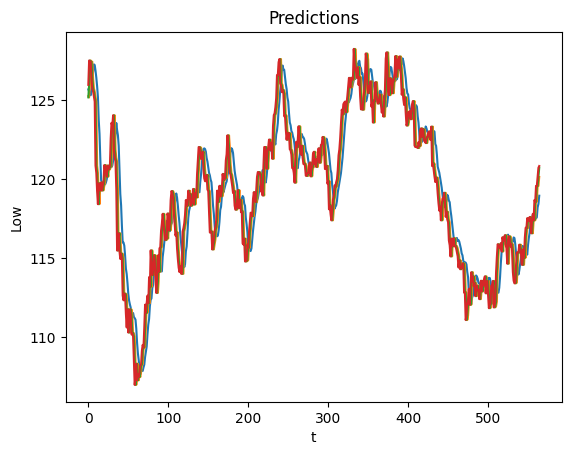

In [510]:
x_axis_values = np.arange(0,len(predictions))

plt.title("Predictions")
plt.xlabel("t")
plt.ylabel(attribute)
plt.plot(x_axis_values, predictions)
plt.plot(x_axis_values, test_y)
plt.show()